Length of list 10


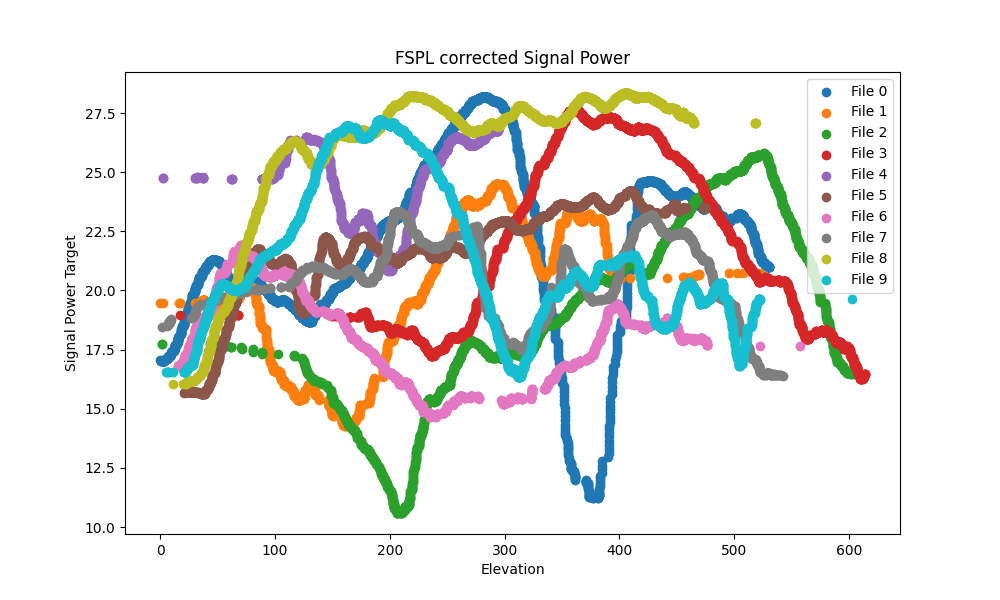

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import noisy_moose as nm
import pickle
import os
from multiprocessing import Pool
import datetime

data_files_active = os.listdir("../output/VZLUSAT/water/")

vzlusat_active = list(i for i in data_files_active if "VZLUSAT-2" in i)


obj_act: list[nm.prepping] = [] #: list[nm.prepping] = [] means that the variable is a list of nm.prepping objects, which makes it possible to autocomplete the methods and attributes of the nm.prepping class.C:\Users\StoreElberg\OneDrive - Aalborg Universitet\Git3\output\VZLUSAT

for i in vzlusat_active[:10]: #choose how many to load
    with open("../output/VZLUSAT/water/" + i, 'rb') as f:
        obj_act.append(pickle.loads(f.read()))

# pointing error calculation
def calculate_pointing_error(set_azimuth, set_elevation, azimuth, elevation):
    """
    Calculate the pointing error given reference (set) and measured azimuth and elevation.
    
    Parameters:
        set_azimuth (array-like): Reference azimuth values in degrees.
        set_elevation (array-like): Reference elevation values in degrees.
        azimuth (array-like): Measured azimuth values in degrees.
        elevation (array-like): Measured elevation values in degrees.
    
    Returns:
        np.ndarray: Pointing error for each pair of reference and measured angles in degrees.
    """
    # Convert degrees to radians
    set_azimuth_rad = np.radians(set_azimuth)
    set_elevation_rad = np.radians(set_elevation)
    azimuth_rad = np.radians(azimuth)
    elevation_rad = np.radians(elevation)
    
    # Compute the pointing error using the great-circle distance formula
    pointing_error_rad = np.arccos(
        np.sin(set_elevation_rad) * np.sin(elevation_rad) +
        np.cos(set_elevation_rad) * np.cos(elevation_rad) * np.cos(azimuth_rad - set_azimuth_rad)
    )
    
    # Convert the pointing error back to degrees
    pointing_error_deg = np.degrees(pointing_error_rad)
    return pointing_error_deg

def remove_outlier(obj):
    outlier_indices = []
    valid_range_bins = int(2 * 11e3 / (250e3 / obj.noise_obj.fft_size))  # Total valid bins for the maximum doppler shift of ±11kHz when sampling rate is 250kHz
    for i , row in enumerate(obj.noise_obj.waterfall):
        fft_data =  10*np.log10(np.squeeze(row))  # FFT data (magnitude spectrum)
        center_bin = obj.noise_obj.fft_size // 2  # Center bin of the FFT, integer division to get an actual number

        # Determine valid bin range for Doppler effect
        valid_min = max(0, center_bin - valid_range_bins // 2)
        valid_max = min(obj.noise_obj.fft_size, center_bin + valid_range_bins // 2)

        # Extract FFT values in the valid range
        valid_fft_values = fft_data[valid_min:valid_max]

        # Find the maximum value in the valid range
        peak_value = np.max(valid_fft_values)


        if (peak_value-np.mean(fft_data)>5):
            outlier_indices.append(i) #If the peak is gucci, then we keep it

    return obj[outlier_indices]#Basically deleting all the points where it was not transmitting



print(f"Length of list {len(obj_act)}")

for i in range(len(obj_act)):
    #first outlier removal using threshold
    idx = np.argwhere(10*np.log10(obj_act[i].noise_obj.signal_abs) > -138) #Threshold set to -138 dBm on the data without the FSPL correction
    obj_act[i]=obj_act[i][idx] #Basically deleting all the points where the moving average is below the threshold

    #second outlier removal using peak detection
    # obj_act[i]=remove_outlier(obj_act[i])

    # Calculate the target values
    clean_sig_abs = np.squeeze(obj_act[i].clean_sig_abs)
    window_size = 99   #
    padded_signal = np.pad(clean_sig_abs, pad_width=window_size // 2, mode='reflect')
    moving_avg = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
    time_ax_avg = obj_act[i].time_ax[:len(moving_avg)]

    squared_errors = (clean_sig_abs - moving_avg) ** 2  # Compute squared errors

    # removing outliers
    obj_act[i]=obj_act[i][np.where(squared_errors < 10 )[0]]

    # Calculate the target values again
    clean_sig_abs = np.squeeze(obj_act[i].clean_sig_abs)
    window_size = 99
    padded_signal = np.pad(clean_sig_abs, pad_width=window_size // 2, mode='reflect')
    moving_avg = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
    time_ax_avg = obj_act[i].time_ax[:len(moving_avg)]

    # obj_act[i]=obj #delimit the object
    obj_act[i].target = moving_avg

    # Calculate pointing error for this object
    pointing_error = calculate_pointing_error(
        set_azimuth=obj_act[i].station_obj.set_azimuth,
        set_elevation=obj_act[i].station_obj.set_elevation,
        azimuth=obj_act[i].station_obj.azimuth,
        elevation=obj_act[i].station_obj.elevation
    )
    # Append the pointing error as a new attribute to the object
    obj_act[i].pointing_error = pointing_error
    
# Plot the first feature (e.g., signal power) for some files
plt.figure(figsize=(10, 6))
for i in range(len(obj_act)):
    plt.scatter(obj_act[i].time_ax,obj_act[i].target, label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time')
plt.ylabel('Signal Power Target')
plt.title('FSPL corrected Signal Power')
plt.legend()
plt.show()